# Supervised Fraud Detection using ETFD dataset from Kaggle
# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve
import shap
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff

# Load Dataset

In [2]:
df = pd.read_csv('../data/ETFD_Dataset.txt', sep='\t')
df

,blockNumber,confirmations,Month,Day,Hour,mean_value_received,variance_value_received,total_received,time_diff_first_last_received,total_tx_sent,total_tx_sent_malicious,total_tx_sent_unique,total_tx_sent_malicious_unique,total_tx_received_malicious_unique,Fraud
0,19664511,201879,4,16,0,0.175190,0.051997,0.700762,246.459167,43.0,0.0,6.0,0.0,0.0,0
1,16217669,3648727,12,19,8,0.084239,0.034468,13.394033,625.489433,62.0,0.0,1.0,0.0,0.0,0
2,14351953,5514270,3,9,10,3.896736,101.819168,467.608309,1884.806134,552.0,0.0,251.0,0.0,0.0,0
3,19753020,113094,4,28,9,0.135540,0.004389,1.490942,225.155556,59.0,0.0,33.0,0.0,0.0,0
4,19076055,790248,1,24,10,0.235717,0.149036,43.372003,937.681377,423.0,0.0,97.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84998,5950996,13816624,7,12,13,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1
84999,5951042,13816578,7,12,13,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1
85000,5951114,13816506,7,12,14,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1
85001,5957365,13810255,7,13,15,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1


In [3]:
df.columns

Index(['blockNumber', 'confirmations', 'Month', 'Day', 'Hour',
       'mean_value_received', 'variance_value_received', 'total_received',
       'time_diff_first_last_received', 'total_tx_sent',
       'total_tx_sent_malicious', 'total_tx_sent_unique',
       'total_tx_sent_malicious_unique', 'total_tx_received_malicious_unique',
       'Fraud'],
      dtype='object')


Shape of Data: (85003, 15)

--- Class Balance (Fraud vs Normal) ---
Fraud
1    0.500029
0    0.499971
Name: proportion, dtype: float64


/var/folders/9j/_8sx8kxj7cl3vnn7_kxmts1m0000gn/T/ipykernel_93084/2161099308.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='coolwarm')


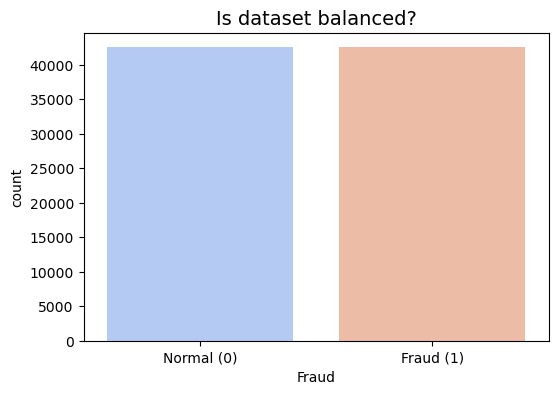


--- Top Features Correlated with Fraud ---
Fraud                                 1.000000
confirmations                         0.880294
total_tx_sent_malicious               0.218554
total_tx_sent_malicious_unique        0.209790
total_tx_received_malicious_unique    0.131387
Month                                 0.097111
Hour                                  0.062414
Day                                  -0.019343
variance_value_received              -0.115796
total_received                       -0.121746
Name: Fraud, dtype: float64
mean_value_received             -0.124467
total_tx_sent_unique            -0.205915
total_tx_sent                   -0.271143
time_diff_first_last_received   -0.376727
blockNumber                     -0.882195
Name: Fraud, dtype: float64


In [4]:
y = df['Fraud']
X = df.drop(columns=['Fraud'])
print(f"\nShape of Data: {df.shape}")

print("\n--- Class Balance (Fraud vs Normal) ---")
print(y.value_counts(normalize=True))

plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette='coolwarm')
plt.title("Is dataset balanced?", fontsize=14)
plt.xticks([0, 1], ['Normal (0)', 'Fraud (1)'])
plt.show()

corr_matrix = df.select_dtypes(include=[np.number]).corr()
fraud_corr = corr_matrix['Fraud'].sort_values(ascending=False)

print("\n--- Top Features Correlated with Fraud ---")
print(fraud_corr.head(10))
print(fraud_corr.tail(5))

In [5]:
# dropping non-informative columns
df_train = df.drop(columns=['blockNumber', 'confirmations'])
df_train.head()

,Month,Day,Hour,mean_value_received,variance_value_received,total_received,time_diff_first_last_received,total_tx_sent,total_tx_sent_malicious,total_tx_sent_unique,total_tx_sent_malicious_unique,total_tx_received_malicious_unique,Fraud
0,4,16,0,0.175190,0.051997,0.700762,246.459167,43.0,0.0,6.0,0.0,0.0,0
1,12,19,8,0.084239,0.034468,13.394033,625.489433,62.0,0.0,1.0,0.0,0.0,0
2,3,9,10,3.896736,101.819168,467.608309,1884.806134,552.0,0.0,251.0,0.0,0.0,0
3,4,28,9,0.135540,0.004389,1.490942,225.155556,59.0,0.0,33.0,0.0,0.0,0
4,1,24,10,0.235717,0.149036,43.372003,937.681377,423.0,0.0,97.0,0.0,0.0,0


In [6]:
# check for missing values
df_train.isnull().sum().sum()

0

In [7]:
df_train.columns

Index(['Month', 'Day', 'Hour', 'mean_value_received',
       'variance_value_received', 'total_received',
       'time_diff_first_last_received', 'total_tx_sent',
       'total_tx_sent_malicious', 'total_tx_sent_unique',
       'total_tx_sent_malicious_unique', 'total_tx_received_malicious_unique',
       'Fraud'],
      dtype='object')

In [8]:
df_train.describe()

,Month,Day,Hour,mean_value_received,variance_value_received,total_received,time_diff_first_last_received,total_tx_sent,total_tx_sent_malicious,total_tx_sent_unique,total_tx_sent_malicious_unique,total_tx_received_malicious_unique,Fraud
count,85003.000000,85003.000000,85003.000000,85003.000000,8.500300e+04,85003.000000,85003.000000,85003.000000,85003.000000,85003.000000,85003.000000,85003.000000,85003.000000
mean,6.058080,15.733951,12.138019,4.607558,4.079768e+03,3972.879905,304.783031,644.205369,49.362646,74.846217,12.049163,0.182076,0.500029
std,3.253529,8.736124,6.610912,31.713870,3.468387e+04,32287.360548,519.420096,1746.820366,215.433491,195.174043,51.611372,1.265924,0.500003
min,1.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,3.000000,8.000000,7.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,6.000000,16.000000,13.000000,0.000000,0.000000e+00,0.000000,0.000000,23.000000,0.000000,2.000000,0.000000,0.000000,1.000000
75%,9.000000,23.000000,18.000000,0.483130,3.821694e-01,22.876177,488.091528,437.000000,1.000000,45.000000,1.000000,0.000000,1.000000
max,12.000000,31.000000,23.000000,750.100000,1.124700e+06,281701.000000,2986.429039,9996.000000,1464.000000,1689.000000,293.000000,13.000000,1.000000


# Create train/validation/test split

In [9]:
X = df_train.drop(columns=['Fraud'])
y = df_train['Fraud']

# Separate out TRAIN set (70%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Split the remaining 30% into VALIDATION (15%) and TEST (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

### `get_model_metrics`

In [10]:
# functions for model comparison & evaluation
# financial cost function
def calculate_financial_cost(fp, fn, cost_fp=50, cost_fn=500):
    """
    Estimates the business dollar cost of the model's errors.
    - cost_fp ($50): churn risk, support tickets for blocked users.
    - cost_fn ($500): average theft amount per fraud transaction.
    """
    return (fp * cost_fp) + (fn * cost_fn)

# metrics function
def get_model_metrics(model, X, y, threshold=0.5, model_name="Model", dataset_name="Val"):
    """
    calculates all metrics for a specific model and dataset at a specific threshold.
    """
    y_prob = model.predict_proba(X)[:, 1]
    
    # pedictions based on set threshold
    y_pred = (y_prob >= threshold).astype(int)
    
    # core metrics
    auc = roc_auc_score(y, y_prob)
    precision = precision_score(y, y_pred, zero_division=0)
    recall = recall_score(y, y_pred, zero_division=0)
    f1 = f1_score(y, y_pred, zero_division=0)
    
    # confusion matrix & cost
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    total_cost = calculate_financial_cost(fp, fn)
    
    # feature importance (top 3) - only for tree models
    top_features = "N/A"
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:3]
        feature_names = X.columns
        top_features = ", ".join([feature_names[i] for i in indices])
    
    return {
        'Model': model_name,
        'Dataset': dataset_name,
        'Threshold': threshold,
        'ROC_AUC': round(auc, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1_Score': round(f1, 4),
        'False_Positives': fp,
        'False_Negatives': fn,
        'Total_Cost ($)': total_cost,
        'Top_3_Features': top_features,
        'Confusion_Matrix': cm
    }

# Baseline Models
## XGBoost

In [11]:
model = XGBClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=5, 
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='logloss'
)

print("Training Model")
model.fit(X_train, y_train)
print("Training Complete!")

# evaluate on VALIDATION set
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)[:, 1]

Training Model
Training Complete!


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:30:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Validation Performance ---
ROC-AUC Score: 0.9991
Precision: 0.9873
Recall: 0.9898
F1 Score: 0.9886

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6375
           1       0.99      0.99      0.99      6375

    accuracy                           0.99     12750
   macro avg       0.99      0.99      0.99     12750
weighted avg       0.99      0.99      0.99     12750

Confusion Matrix:
[[6294   81]
 [  65 6310]]


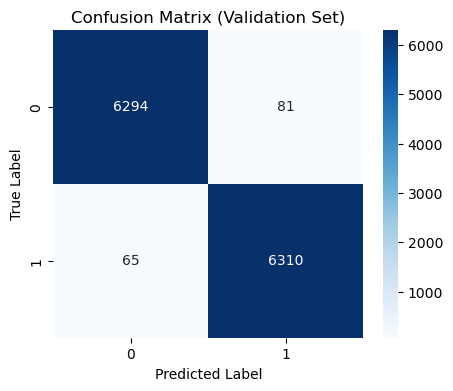

In [12]:
# metrics
print("\n--- Validation Performance ---")
print(f"ROC-AUC Score: {roc_auc_score(y_val, y_prob):.4f}")
print(f"Precision: {precision_score(y_val, y_pred, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_val, y_pred, zero_division=0):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred, zero_division=0):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_val, y_pred))
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Validation Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

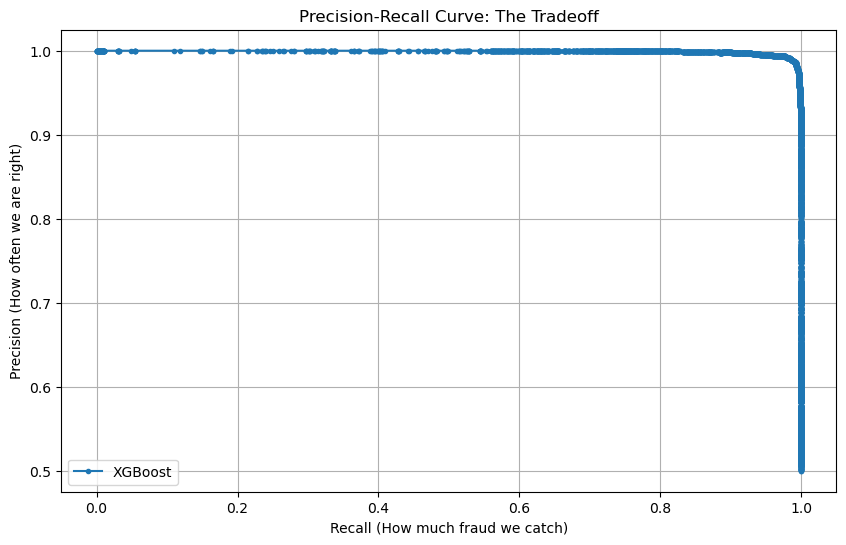

To achieve 0.9951 Precision (fewer false alerts):
We must accept a Recall of 0.9523 (catching slightly less fraud).
The threshold to set in our production engine is: 0.8725


In [13]:
# precision-recall curve
y_scores = model.predict_proba(X_val)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores)

plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, marker='.', label='XGBoost')
plt.xlabel('Recall (How much fraud we catch)')
plt.ylabel('Precision (How often we are right)')
plt.title('Precision-Recall Curve: The Tradeoff')
plt.grid(True)
plt.legend()
plt.show()

# say we want to minimize False Positives (High Precision)
# look for the threshold where Precision is at least 99.5%
desired_precision = 0.995
idx = np.where(precisions >= desired_precision)[0][0]

print(f"To achieve {precisions[idx]:.4f} Precision (fewer false alerts):")
print(f"We must accept a Recall of {recalls[idx]:.4f} (catching slightly less fraud).")
print(f"The threshold to set in our production engine is: {thresholds[idx]:.4f}")

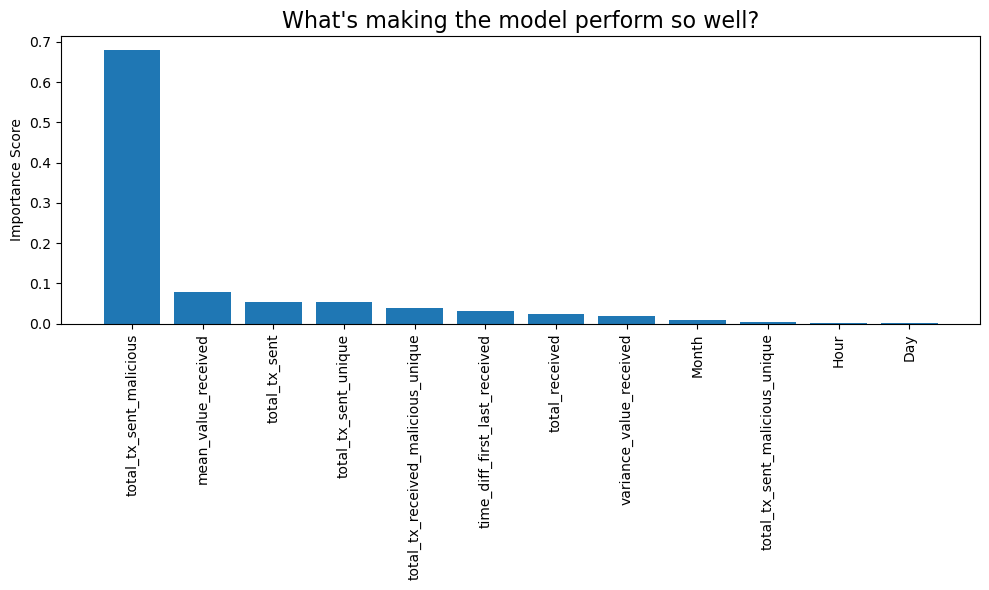

Top 5 Features Driving the Model:
1. total_tx_sent_malicious (0.6795)
2. mean_value_received (0.0784)
3. total_tx_sent (0.0549)
4. total_tx_sent_unique (0.0531)
5. total_tx_received_malicious_unique (0.0395)


In [14]:
# feature importance
features = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("What's making the model perform so well?", fontsize=16)
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

print("Top 5 Features Driving the Model:")
for i in range(5):
    print(f"{i+1}. {features[indices[i]]} ({importances[indices[i]]:.4f})")

## Logistic Regression

In [15]:
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

print("Training ...")
lr_pipeline.fit(X_train, y_train)

y_prob_lr = lr_pipeline.predict_proba(X_val)[:, 1]
roc_lr = roc_auc_score(y_val, y_prob_lr)

print(f"Logistic Regression Precision: {precision_score(y_val, (y_prob_lr >= 0.5).astype(int), zero_division=0):.4f}")
print(f"Logistic Regression Recall: {recall_score(y_val, (y_prob_lr >= 0.5).astype(int), zero_division=0):.4f}")
print(f"Logistic Regression ROC-AUC: {roc_lr:.4f}")
print(f"XGBoost ROC-AUC (Recall): {roc_auc_score(y_val, y_prob):.4f}")

Training ...
Logistic Regression Precision: 0.7345
Logistic Regression Recall: 0.9114
Logistic Regression ROC-AUC: 0.8879
XGBoost ROC-AUC (Recall): 0.9991


# XGBoost

### `train_tuned_xgboost`

In [16]:
def train_tuned_xgboost(X_train, y_train, X_val, y_val, model_name="XGBoost"):
    model = XGBClassifier(
        n_estimators=1000,      # High number, but Early Stopping will cut it short
        learning_rate=0.05,     # Lower rate = better generalization (slower learning)
        max_depth=4,            # Shallower trees = less overfitting (Default is 6)
        subsample=0.8,          # Use only 80% of data per tree (adds randomness)
        colsample_bytree=0.8,   # Use only 80% of features per tree
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        early_stopping_rounds=20 # stops if no improvement for 20 rounds
    )
    
    print(f"--- Training {model_name} with Early Stopping ---")
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False  #see the logs
    )
    
    # how many trees it actually used
    print(f"Best Iteration: {model.best_iteration}")
    return model

### `evaluate_fraud_model`

In [17]:
# model evaluation function
def evaluate_fraud_model(model, X_val, y_val, threshold_target_recall=0.80):
    y_prob = model.predict_proba(X_val)[:, 1]
    
    # ROC-AUC
    auc_score = roc_auc_score(y_val, y_prob)
    print(f"ROC-AUC Score: {auc_score:.4f}")

    precision_score_val = precision_score(y_val, (y_prob >= 0.5).astype(int), zero_division=0)
    recall_score_val = recall_score(y_val, (y_prob >= 0.5).astype(int), zero_division=0)
    f1_score_val = f1_score(y_val, (y_prob >= 0.5).astype(int), zero_division=0)
    print(f"Precision (at 0.5 threshold): {precision_score_val:.4f}")
    print(f"Recall (at 0.5 threshold): {recall_score_val:.4f}")
    print(f"F1 Score (at 0.5 threshold): {f1_score_val:.4f}")
    
    # Precision-Recall Curve
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_prob)
    
    # Find the Threshold for Target Recall (e.g., Catch 80% of Fraud)
    # We look for the index where Recall is closest to 0.80
    idx = np.argmin(np.abs(recalls - threshold_target_recall))
    best_threshold = thresholds[idx]
    current_precision = precisions[idx]
    
    print(f"\n--- Operating Point (Target Recall ~{threshold_target_recall*100}%) ---")
    print(f"Threshold: {best_threshold:.4f}")
    print(f"Precision: {current_precision:.4f} (When we flag, we are {current_precision*100:.1f}% correct)")
    print(f"Recall:    {recalls[idx]:.4f} (We catch {recalls[idx]*100:.1f}% of total fraud)")
    
    # Business Impact (Confusion Matrix at this Threshold)
    y_pred_custom = (y_prob >= best_threshold).astype(int)
    cm = confusion_matrix(y_val, y_pred_custom)
    print(cm)
    
    tn, fp, fn, tp = cm.ravel()
    
    print("\n--- Business Impact Narrative ---")
    print(f"1. FRAUD CAUGHT: {tp} transactions blocked.")
    print(f"2. FALSE ALERTS: {fp} legitimate users annoyed.")
    print(f"3. MISSED FRAUD: {fn} criminals got away.")
    
    print(f"\nPRODUCT NARRATIVE: \"At a threshold of {best_threshold:.2f}, we catch {tp} frauds. However, we incorrectly flag {fp} users.")
    if fp > 50:
        print("Recommendation: Since False Positives are high, use this as a STEP-UP trigger (2FA), not a hard block.\"")
    else:
        print("Recommendation: False Positives are low. We can confidently AUTO-BLOCK these transactions.\"")
        
    # PR Curve
    plt.figure(figsize=(8, 5))
    plt.plot(recalls, precisions, marker='.', label='XGBoost Tuned')
    plt.scatter(recalls[idx], precisions[idx], color='red', label='Chosen Operating Point', zorder=5)
    plt.title(f'Precision-Recall Curve (AUC={auc_score:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return y_prob

--- Training Scenario A (Full) with Early Stopping ---


/opt/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [18:30:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Best Iteration: 980

=== EVALUATION: SCENARIO A (Full Features) ===
ROC-AUC Score: 0.9993
Precision (at 0.5 threshold): 0.9898
Recall (at 0.5 threshold): 0.9914
F1 Score (at 0.5 threshold): 0.9906

--- Operating Point (Target Recall ~90.0%) ---
Threshold: 0.9750
Precision: 0.9977 (When we flag, we are 99.8% correct)
Recall:    0.9001 (We catch 90.0% of total fraud)
[[6362   13]
 [ 637 5738]]

--- Business Impact Narrative ---
1. FRAUD CAUGHT: 5738 transactions blocked.
2. FALSE ALERTS: 13 legitimate users annoyed.
3. MISSED FRAUD: 637 criminals got away.

PRODUCT NARRATIVE: "At a threshold of 0.97, we catch 5738 frauds. However, we incorrectly flag 13 users.
Recommendation: False Positives are low. We can confidently AUTO-BLOCK these transactions."


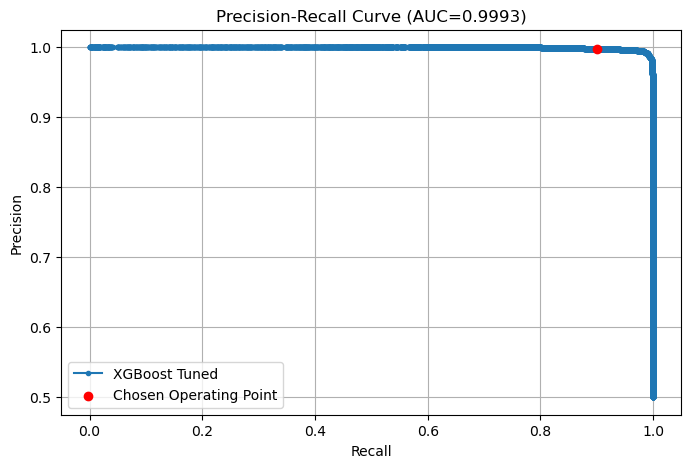

In [18]:
# Scenario A: Full Context
model_a_tuned = train_tuned_xgboost(X_train, y_train, X_val, y_val, model_name="Scenario A (Full)")
print("\n=== EVALUATION: SCENARIO A (Full Features) ===")
_ = evaluate_fraud_model(model_a_tuned, X_val, y_val, threshold_target_recall=0.90)

In [19]:
df.columns

Index(['blockNumber', 'confirmations', 'Month', 'Day', 'Hour',
       'mean_value_received', 'variance_value_received', 'total_received',
       'time_diff_first_last_received', 'total_tx_sent',
       'total_tx_sent_malicious', 'total_tx_sent_unique',
       'total_tx_sent_malicious_unique', 'total_tx_received_malicious_unique',
       'Fraud'],
      dtype='object')

--- Training Scenario B (Behavior) with Early Stopping ---


/opt/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [18:30:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Best Iteration: 999

=== EVALUATION: SCENARIO B (Behavior Only) ===
ROC-AUC Score: 0.9799
Precision (at 0.5 threshold): 0.9029
Recall (at 0.5 threshold): 0.9511
F1 Score (at 0.5 threshold): 0.9264

--- Operating Point (Target Recall ~80.0%) ---
Threshold: 0.8115
Precision: 0.9668 (When we flag, we are 96.7% correct)
Recall:    0.8000 (We catch 80.0% of total fraud)
[[6200  175]
 [1275 5100]]

--- Business Impact Narrative ---
1. FRAUD CAUGHT: 5100 transactions blocked.
2. FALSE ALERTS: 175 legitimate users annoyed.
3. MISSED FRAUD: 1275 criminals got away.

PRODUCT NARRATIVE: "At a threshold of 0.81, we catch 5100 frauds. However, we incorrectly flag 175 users.
Recommendation: Since False Positives are high, use this as a STEP-UP trigger (2FA), not a hard block."


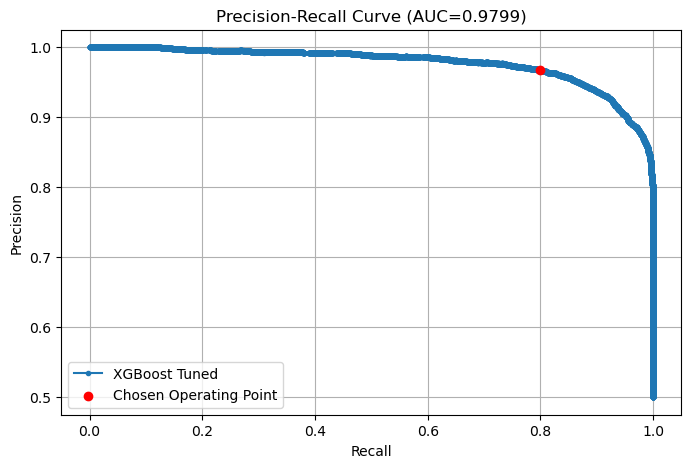

In [20]:
# Scenario B: Behavior Only (Drop Malicious Activity Features)
malicious_cols = ['total_tx_sent_malicious', 'total_tx_sent_malicious_unique', 'total_tx_received_malicious_unique']
X_train_beh = X_train.drop(columns=malicious_cols)
X_val_beh = X_val.drop(columns=malicious_cols)

model_b_tuned = train_tuned_xgboost(X_train_beh, y_train, X_val_beh, y_val, model_name="Scenario B (Behavior)")

print("\n=== EVALUATION: SCENARIO B (Behavior Only) ===")
_ = evaluate_fraud_model(model_b_tuned, X_val_beh, y_val, threshold_target_recall=0.80)

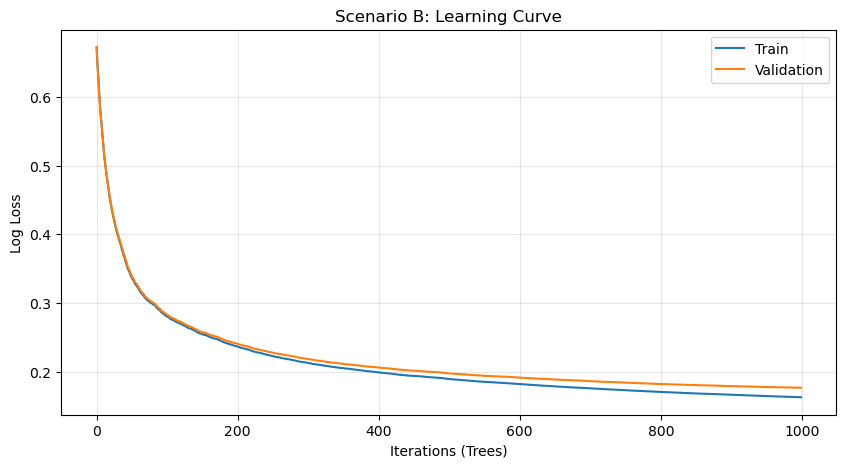

SUCCESS: Train and Validation track closely. Good generalization.
[[6200  175]
 [1277 5098]]


In [21]:
# training vs validation loss to monitor overfitting
def plot_learning_curves(model, model_name="XGBoost"):
    results = model.evals_result()
    epochs = len(results['validation_0']['logloss'])
    x_axis = range(0, epochs)
    
    plt.figure(figsize=(10, 5))
    plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
    plt.plot(x_axis, results['validation_1']['logloss'], label='Validation')
    plt.legend()
    plt.ylabel('Log Loss')
    plt.xlabel('Iterations (Trees)')
    plt.title(f'{model_name}: Learning Curve')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    if results['validation_1']['logloss'][-1] > results['validation_0']['logloss'][-1] + 0.1:
        print("WARNING: Gap between Train and Val suggests slight overfitting.")
    else:
        print("SUCCESS: Train and Validation track closely. Good generalization.")

# cm at custom threshold
def plot_custom_confusion_matrix(model, X_val, y_val, threshold):
    y_prob = model.predict_proba(X_val)[:, 1]
    # Convert to 0/1 using custom threshold
    y_pred_custom = (y_prob >= threshold).astype(int)
    
    cm = confusion_matrix(y_val, y_pred_custom)
    print(cm)
    
    # plt.figure(figsize=(7, 6))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})

    # plt.title(f'Confusion Matrix @ Threshold {threshold:.4f}', fontsize=14, fontweight="bold")
    # plt.ylabel('Actual Label', fontsize=12)
    # plt.xlabel('Predicted Label', fontsize=12)
    # plt.xticks([0.5, 1.5], ['Normal', 'Fraud'])
    # plt.yticks([0.5, 1.5], ['Normal', 'Fraud'])
    # plt.show()
    z_text = [[str(y) for y in x] for x in cm]

    fig3 = ff.create_annotated_heatmap(z=cm, x=['Predicted Normal', 'Predicted Fraud'],
                                    y=['Actual Normal', 'Actual Fraud'],
                                    annotation_text=z_text, colorscale='Blues')

    fig3.update_layout(title='<b>Confusion Matrix @ Threshold 0.81</b>', height=500)
    fig3.write_html("../assets/asset3_cm_interactive.html")
    fig3.show()

plot_learning_curves(model_b_tuned, "Scenario B")
# Confusion Matrix (Using the threshold you found: 0.8115)
plot_custom_confusion_matrix(model_b_tuned, X_val_beh, y_val, threshold=0.8115)

In [22]:
# PR Curve with Operating Point: Scenario B XGB
y_prob_b = model_b_tuned.predict_proba(X_val_beh)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_val, y_prob_b)

idx = np.argmin(np.abs(recalls - 0.80))

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=recalls, y=precisions, name='XGBoost (Behavior)',
                         line=dict(color='#27AE60', width=3)))
fig2.add_trace(go.Scatter(x=[recalls[idx]], y=[precisions[idx]], mode='markers',
                         name=f'Operating Point (Thresh {thresholds[idx]:.2f})',
                         marker=dict(color='#C0392B', size=15)))

fig2.update_layout(title='<b>Precision-Recall Curve: Optimizing for 80% Capture</b>',
                   xaxis_title='Recall (Fraud Caught)',
                   yaxis_title='Precision (False Alarm Rate)',
                   template='plotly_white', height=600)
fig2.write_html("../assets/asset2_pr_interactive.html")
fig2.show()

# RandomForest

In [23]:
def train_rf(X_train, y_train, model_name="Random Forest"):
    print(f"Training {model_name}...")
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    return model

# RF Scenario A: Full Context
rf_model_a = train_rf(X_train, y_train, "RF Scenario A (Full)")

# RF Scenario B: Behavior Only
malicious_cols = ['total_tx_sent_malicious', 'total_tx_sent_malicious_unique', 'total_tx_received_malicious_unique']
X_train_beh = X_train.drop(columns=malicious_cols)
X_val_beh = X_val.drop(columns=malicious_cols)

rf_model_b = train_rf(X_train_beh, y_train, "RF Scenario B (Behavior)")

Training RF Scenario A (Full)...
Training RF Scenario B (Behavior)...


RF EVALUATION: SCENARIO A (Full)
ROC-AUC Score: 0.9984
Precision (at 0.5 threshold): 0.9846
Recall (at 0.5 threshold): 0.9846
F1 Score (at 0.5 threshold): 0.9846

--- Operating Point (Target Recall ~90.0%) ---
Threshold: 0.9188
Precision: 0.9960 (When we flag, we are 99.6% correct)
Recall:    0.9001 (We catch 90.0% of total fraud)
[[6352   23]
 [ 637 5738]]

--- Business Impact Narrative ---
1. FRAUD CAUGHT: 5738 transactions blocked.
2. FALSE ALERTS: 23 legitimate users annoyed.
3. MISSED FRAUD: 637 criminals got away.

PRODUCT NARRATIVE: "At a threshold of 0.92, we catch 5738 frauds. However, we incorrectly flag 23 users.
Recommendation: False Positives are low. We can confidently AUTO-BLOCK these transactions."


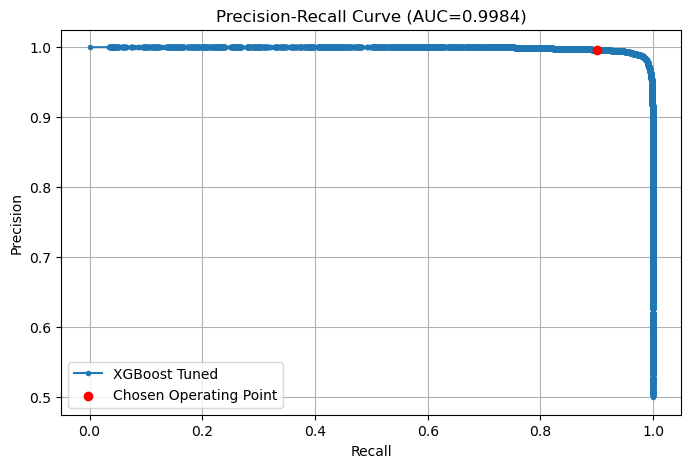


RF EVALUATION: SCENARIO B (Behavior)
ROC-AUC Score: 0.9732
Precision (at 0.5 threshold): 0.8773
Recall (at 0.5 threshold): 0.9644
F1 Score (at 0.5 threshold): 0.9188

--- Operating Point (Target Recall ~80.0%) ---
Threshold: 0.7070
Precision: 0.9471 (When we flag, we are 94.7% correct)
Recall:    0.8000 (We catch 80.0% of total fraud)
[[6090  285]
 [1275 5100]]

--- Business Impact Narrative ---
1. FRAUD CAUGHT: 5100 transactions blocked.
2. FALSE ALERTS: 285 legitimate users annoyed.
3. MISSED FRAUD: 1275 criminals got away.

PRODUCT NARRATIVE: "At a threshold of 0.71, we catch 5100 frauds. However, we incorrectly flag 285 users.
Recommendation: Since False Positives are high, use this as a STEP-UP trigger (2FA), not a hard block."


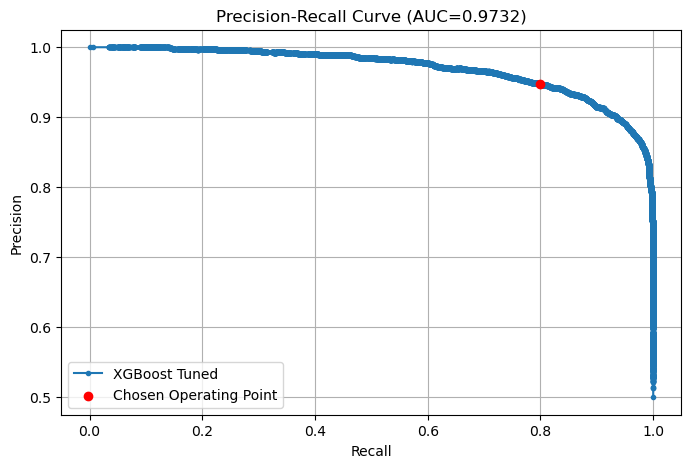

In [24]:
# eval scenario A (RF)
print("RF EVALUATION: SCENARIO A (Full)")
_ = evaluate_fraud_model(rf_model_a, X_val, y_val, threshold_target_recall=0.90)

# eval scenario B (RF)
print("\nRF EVALUATION: SCENARIO B (Behavior)")
_ = evaluate_fraud_model(rf_model_b, X_val_beh, y_val, threshold_target_recall=0.80)

# Evaluation

In [25]:
# prepare final metrics table
metrics_rows = []

# SCENARIO A (Full) Thresholds
# found ~0.9750 for XGB A in previous run
thresh_a = 0.9750 

# 1. XGBoost Scenario A
metrics_rows.append(get_model_metrics(model_a_tuned, X_train, y_train, thresh_a, "XGB_Scenario_A", "Train"))
metrics_rows.append(get_model_metrics(model_a_tuned, X_val, y_val,   thresh_a, "XGB_Scenario_A", "Validation"))

# 2. RF Scenario A
metrics_rows.append(get_model_metrics(rf_model_a, X_train, y_train, thresh_a, "RF_Scenario_A",  "Train"))
metrics_rows.append(get_model_metrics(rf_model_a, X_val, y_val,   thresh_a, "RF_Scenario_A",  "Validation"))


# SCENARIO B (Behavior) Thresholds
# found ~0.8115 for XGB B in previous run
thresh_b = 0.8115

# 3. XGBoost Scenario B
metrics_rows.append(get_model_metrics(model_b_tuned, X_train_beh, y_train, thresh_b, "XGB_Scenario_B", "Train"))
metrics_rows.append(get_model_metrics(model_b_tuned, X_val_beh,   y_val,   thresh_b, "XGB_Scenario_B", "Validation"))

# 4. RF Scenario B
metrics_rows.append(get_model_metrics(rf_model_b, X_train_beh, y_train, thresh_b, "RF_Scenario_B",  "Train"))
metrics_rows.append(get_model_metrics(rf_model_b, X_val_beh,   y_val,   thresh_b, "RF_Scenario_B",  "Validation"))

df_metrics = pd.DataFrame(metrics_rows)
cols = ['Model', 'Dataset', 'Threshold', 'ROC_AUC', 'Precision', 'Recall', 'F1_Score', 'False_Positives', 'False_Negatives','Confusion_Matrix', 'Top_3_Features', 'Total_Cost ($)']
df_metrics = df_metrics[cols]

pd.set_option('display.max_columns', None)
print("Final Model Performance Audit")
display(df_metrics)

Final Model Performance Audit


,Model,Dataset,Threshold,ROC_AUC,Precision,Recall,F1_Score,False_Positives,False_Negatives,Confusion_Matrix,Top_3_Features,Total_Cost ($)
0,XGB_Scenario_A,Train,0.9750,0.9998,0.9999,0.9020,0.9484,3,2915,"[[29746, 3], [2915, 26838]]","total_tx_sent_malicious, total_tx_sent_malicio...",1457650
1,XGB_Scenario_A,Validation,0.9750,0.9993,0.9977,0.8998,0.9462,13,639,"[[6362, 13], [639, 5736]]","total_tx_sent_malicious, total_tx_sent_malicio...",320150
2,RF_Scenario_A,Train,0.9750,0.9992,0.9999,0.7756,0.8736,2,6677,"[[29747, 2], [6677, 23076]]","total_tx_sent_malicious, total_tx_sent_malicio...",3338600
3,RF_Scenario_A,Validation,0.9750,0.9984,0.9992,0.7787,0.8753,4,1411,"[[6371, 4], [1411, 4964]]","total_tx_sent_malicious, total_tx_sent_malicio...",705700
4,XGB_Scenario_B,Train,0.8115,0.9835,0.9707,0.8127,0.8847,731,5573,"[[29018, 731], [5573, 24180]]","time_diff_first_last_received, total_tx_sent, ...",2823050
5,XGB_Scenario_B,Validation,0.8115,0.9799,0.9668,0.7997,0.8753,175,1277,"[[6200, 175], [1277, 5098]]","time_diff_first_last_received, total_tx_sent, ...",647250
6,RF_Scenario_B,Train,0.8115,0.9772,0.9741,0.6725,0.7957,532,9744,"[[29217, 532], [9744, 20009]]","total_tx_sent, time_diff_first_last_received, ...",4898600
7,RF_Scenario_B,Validation,0.8115,0.9732,0.9696,0.6557,0.7823,131,2195,"[[6244, 131], [2195, 4180]]","total_tx_sent, time_diff_first_last_received, ...",1104050


In [26]:
print(df_metrics)

            Model     Dataset  Threshold  ROC_AUC  Precision  Recall  \
0  XGB_Scenario_A       Train     0.9750   0.9998     0.9999  0.9020   
1  XGB_Scenario_A  Validation     0.9750   0.9993     0.9977  0.8998   
2   RF_Scenario_A       Train     0.9750   0.9992     0.9999  0.7756   
3   RF_Scenario_A  Validation     0.9750   0.9984     0.9992  0.7787   
4  XGB_Scenario_B       Train     0.8115   0.9835     0.9707  0.8127   
5  XGB_Scenario_B  Validation     0.8115   0.9799     0.9668  0.7997   
6   RF_Scenario_B       Train     0.8115   0.9772     0.9741  0.6725   
7   RF_Scenario_B  Validation     0.8115   0.9732     0.9696  0.6557   

   F1_Score  False_Positives  False_Negatives               Confusion_Matrix  \
0    0.9484                3             2915    [[29746, 3], [2915, 26838]]   
1    0.9462               13              639      [[6362, 13], [639, 5736]]   
2    0.8736                2             6677    [[29747, 2], [6677, 23076]]   
3    0.8753                4   

## Test set

In [27]:
# real world example: test set with 5% fraud
# held-out X_test (50/50) and downsample the Fraud cases

# recombine X_test and y_test
test_df = X_test.copy()
test_df['Fraud'] = y_test

# separate Fraud and Normal
fraud_df = test_df[test_df['Fraud'] == 1]
normal_df = test_df[test_df['Fraud'] == 0]

# downsample Fraud to be 5% of the total
# Target: Fraud = 5% -> Normal = 95%
# Count Normal = 6300 (approx)
# Needed Fraud = 6300 * (5/95) ≈ 330
fraud_downsampled = fraud_df.sample(n=330, random_state=42)

df_test_imbalanced = pd.concat([normal_df, fraud_downsampled])
X_test_real = df_test_imbalanced.drop(columns=['Fraud'])
y_test_real = df_test_imbalanced['Fraud']

print(f"Realistic Test Set Shape: {X_test_real.shape}")
print(f"Fraud Rate: {y_test_real.mean():.4f}")

Realistic Test Set Shape: (6705, 12)
Fraud Rate: 0.0492


In [28]:
# Evaluate XGB Scenarios A & B + RF A & B on this Test Set
X_test_real_beh = X_test_real.drop(columns=malicious_cols)

real_world_metrics = get_model_metrics(
    model_a_tuned, 
    X_test_real, 
    y_test_real, 
    thresh_a, 
    "XGB_Scenario_A", 
    "TEST_REALISTIC (5% Fraud)"
)

df_metrics = pd.concat([df_metrics, pd.DataFrame([real_world_metrics])], ignore_index=True)

real_world_metrics = get_model_metrics(
    model_b_tuned, 
    X_test_real_beh, 
    y_test_real, 
    thresh_b, 
    "XGB_Scenario_B", 
    "TEST_REALISTIC (5% Fraud)"
)

df_metrics = pd.concat([df_metrics, pd.DataFrame([real_world_metrics])], ignore_index=True)

real_world_metrics = get_model_metrics(
    rf_model_a, 
    X_test_real, 
    y_test_real, 
    thresh_a, 
    "RF_Scenario_A", 
    "TEST_REALISTIC (5% Fraud)"
)

df_metrics = pd.concat([df_metrics, pd.DataFrame([real_world_metrics])], ignore_index=True)

real_world_metrics = get_model_metrics(
    rf_model_b, 
    X_test_real_beh, 
    y_test_real, 
    thresh_b, 
    "RF_Scenario_B", 
    "TEST_REALISTIC (5% Fraud)"
)

df_metrics = pd.concat([df_metrics, pd.DataFrame([real_world_metrics])], ignore_index=True)
display(df_metrics.tail(5))

,Model,Dataset,Threshold,ROC_AUC,Precision,Recall,F1_Score,False_Positives,False_Negatives,Confusion_Matrix,Top_3_Features,Total_Cost ($)
7,RF_Scenario_B,Validation,0.8115,0.9732,0.9696,0.6557,0.7823,131,2195,"[[6244, 131], [2195, 4180]]","total_tx_sent, time_diff_first_last_received, ...",1104050
8,XGB_Scenario_A,TEST_REALISTIC (5% Fraud),0.9750,0.9995,0.9830,0.8758,0.9263,5,41,"[[6370, 5], [41, 289]]","total_tx_sent_malicious, total_tx_sent_malicio...",20750
9,XGB_Scenario_B,TEST_REALISTIC (5% Fraud),0.8115,0.9816,0.6148,0.8030,0.6965,166,65,"[[6209, 166], [65, 265]]","time_diff_first_last_received, total_tx_sent, ...",40800
10,RF_Scenario_A,TEST_REALISTIC (5% Fraud),0.9750,0.9988,0.9961,0.7727,0.8703,1,75,"[[6374, 1], [75, 255]]","total_tx_sent_malicious, total_tx_sent_malicio...",37550
11,RF_Scenario_B,TEST_REALISTIC (5% Fraud),0.8115,0.9757,0.6210,0.7000,0.6581,141,99,"[[6234, 141], [99, 231]]","total_tx_sent, time_diff_first_last_received, ...",56550


# Model Evaluations

In [29]:
df_metrics

,Model,Dataset,Threshold,ROC_AUC,Precision,Recall,F1_Score,False_Positives,False_Negatives,Confusion_Matrix,Top_3_Features,Total_Cost ($)
0,XGB_Scenario_A,Train,0.9750,0.9998,0.9999,0.9020,0.9484,3,2915,"[[29746, 3], [2915, 26838]]","total_tx_sent_malicious, total_tx_sent_malicio...",1457650
1,XGB_Scenario_A,Validation,0.9750,0.9993,0.9977,0.8998,0.9462,13,639,"[[6362, 13], [639, 5736]]","total_tx_sent_malicious, total_tx_sent_malicio...",320150
2,RF_Scenario_A,Train,0.9750,0.9992,0.9999,0.7756,0.8736,2,6677,"[[29747, 2], [6677, 23076]]","total_tx_sent_malicious, total_tx_sent_malicio...",3338600
3,RF_Scenario_A,Validation,0.9750,0.9984,0.9992,0.7787,0.8753,4,1411,"[[6371, 4], [1411, 4964]]","total_tx_sent_malicious, total_tx_sent_malicio...",705700
4,XGB_Scenario_B,Train,0.8115,0.9835,0.9707,0.8127,0.8847,731,5573,"[[29018, 731], [5573, 24180]]","time_diff_first_last_received, total_tx_sent, ...",2823050
5,XGB_Scenario_B,Validation,0.8115,0.9799,0.9668,0.7997,0.8753,175,1277,"[[6200, 175], [1277, 5098]]","time_diff_first_last_received, total_tx_sent, ...",647250
6,RF_Scenario_B,Train,0.8115,0.9772,0.9741,0.6725,0.7957,532,9744,"[[29217, 532], [9744, 20009]]","total_tx_sent, time_diff_first_last_received, ...",4898600
7,RF_Scenario_B,Validation,0.8115,0.9732,0.9696,0.6557,0.7823,131,2195,"[[6244, 131], [2195, 4180]]","total_tx_sent, time_diff_first_last_received, ...",1104050
8,XGB_Scenario_A,TEST_REALISTIC (5% Fraud),0.9750,0.9995,0.9830,0.8758,0.9263,5,41,"[[6370, 5], [41, 289]]","total_tx_sent_malicious, total_tx_sent_malicio...",20750
9,XGB_Scenario_B,TEST_REALISTIC (5% Fraud),0.8115,0.9816,0.6148,0.8030,0.6965,166,65,"[[6209, 166], [65, 265]]","time_diff_first_last_received, total_tx_sent, ...",40800


In [30]:
print(df_metrics)

             Model                    Dataset  Threshold  ROC_AUC  Precision  \
0   XGB_Scenario_A                      Train     0.9750   0.9998     0.9999   
1   XGB_Scenario_A                 Validation     0.9750   0.9993     0.9977   
2    RF_Scenario_A                      Train     0.9750   0.9992     0.9999   
3    RF_Scenario_A                 Validation     0.9750   0.9984     0.9992   
4   XGB_Scenario_B                      Train     0.8115   0.9835     0.9707   
5   XGB_Scenario_B                 Validation     0.8115   0.9799     0.9668   
6    RF_Scenario_B                      Train     0.8115   0.9772     0.9741   
7    RF_Scenario_B                 Validation     0.8115   0.9732     0.9696   
8   XGB_Scenario_A  TEST_REALISTIC (5% Fraud)     0.9750   0.9995     0.9830   
9   XGB_Scenario_B  TEST_REALISTIC (5% Fraud)     0.8115   0.9816     0.6148   
10   RF_Scenario_A  TEST_REALISTIC (5% Fraud)     0.9750   0.9988     0.9961   
11   RF_Scenario_B  TEST_REALISTIC (5% F

In [31]:
# COST BASELINE: Do-Nothing Model
# predict all as Normal (0)
y_pred_none = np.zeros_like(y_test_real)

cm_none = confusion_matrix(y_test_real, y_pred_none)
tn_none, fp_none, fn_none, tp_none = cm_none.ravel()

cost_none = calculate_financial_cost(fp_none, fn_none, cost_fp=50, cost_fn=500)

print("Do-nothing baseline on TEST_REALISTIC:")
print("Confusion matrix:", cm_none)
print(f"False Positives: {fp_none}, False Negatives: {fn_none}")
print(f"Total Cost: ${cost_none:,}")

Do-nothing baseline on TEST_REALISTIC:
Confusion matrix: [[6375    0]
 [ 330    0]]
False Positives: 0, False Negatives: 330
Total Cost: $165,000


In [32]:
# baseline_metrics = {
#     'Model': 'Baseline_None',
#     'Dataset': 'TEST_REALISTIC (5% Fraud)',
#     'Threshold': 0.0,
#     'ROC_AUC': np.nan,
#     'Precision': 0.0,
#     'Recall': 0.0,
#     'F1_Score': 0.0,
#     'False_Positives': int(fp_none),
#     'False_Negatives': int(fn_none),
#     'Total_Cost ($)': int(cost_none),
#     'Top_3_Features': 'N/A'
# }

# df_metrics = pd.concat([df_metrics, pd.DataFrame([baseline_metrics])], ignore_index=True)
# display(df_metrics.tail(5))

In [ ]:
# Financial Impact Analysis
cost_fn_base = 330 * 500
cost_fp_base = 0
total_base = cost_fn_base + cost_fp_base

cost_fn_model = 65 * 500
cost_fp_model = 166 * 50
total_model = cost_fn_model + cost_fp_model
y_offset = total_base * 0.05

fig6 = go.Figure()
# Cost of Theft: FN (Red)
fig6.add_trace(go.Bar(
    name='Cost of Theft (FN)',
    x=['Baseline Strategy<br>(Do Nothing)', 'Proposed Strategy<br>(XGBoost Scenario B)'],
    y=[cost_fn_base, cost_fn_model],
    marker_color='#E74C3C',
    text=[f"${cost_fn_base:,.0f}", f"${cost_fn_model:,.0f}"],
    textposition='inside',
    insidetextanchor='middle',
    textfont=dict(color='white'),
    hovertemplate='Theft Cost: %{y:$,.0f}<extra></extra>'
))

# Cost of Friction: FP (Yellow)
fig6.add_trace(go.Bar(
    name='Cost of Friction (FP)',
    x=['Baseline Strategy<br>(Do Nothing)', 'Proposed Strategy<br>(XGBoost Scenario B)'],
    y=[cost_fp_base, cost_fp_model],
    marker_color='#F1C40F',
    text=[f"${cost_fp_base:,.0f}", f"${cost_fp_model:,.0f}"],
    textposition='inside',
    insidetextanchor='middle',
    textfont=dict(color='black'),
    hovertemplate='Friction Cost: %{y:$,.0f}<extra></extra>'
))

fig6.add_trace(go.Scatter(
    x=['Baseline Strategy<br>(Do Nothing)', 'Proposed Strategy<br>(XGBoost Scenario B)'],
    y=[total_base, total_model],
    mode='text',
    text=[f"<b>Total: ${total_base:,.0f}</b>", f"<b>Total: ${total_model:,.0f}</b>"],
    textposition="top center",
    textfont=dict(size=14, color="black"),
    showlegend=False
))

fig6.update_layout(
    barmode='stack',
    title='<b>Financial Impact Analysis: $124k Savings per Batch</b>',
    yaxis_title='Estimated Cost ($)',
    template='plotly_white',
    height=550,
    yaxis=dict(range=[0, total_base * 1.15]),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig6.add_annotation(
    x=1, y=total_model + y_offset,
    xref="x", yref="y",
    text=f"<b>NET SAVINGS: ${(total_base - total_model):,.0f}</b>",
    showarrow=True,
    arrowhead=2,
    arrowsize=1,
    arrowwidth=2,
    ax=0,
    ay=-150,
    font=dict(size=14, color="green", family="Arial Black")
)

fig6.write_html("../assets/asset6_financial_impact.html")
fig6.show()

In [34]:
print(df_metrics.to_markdown(index=False))

| Model          | Dataset                   |   Threshold |   ROC_AUC |   Precision |   Recall |   F1_Score |   False_Positives |   False_Negatives | Confusion_Matrix   | Top_3_Features                                                                              |   Total_Cost ($) |
|:---------------|:--------------------------|------------:|----------:|------------:|---------:|-----------:|------------------:|------------------:|:-------------------|:--------------------------------------------------------------------------------------------|-----------------:|
| XGB_Scenario_A | Train                     |      0.975  |    0.9998 |      0.9999 |   0.902  |     0.9484 |                 3 |              2915 | [[29746     3]     | total_tx_sent_malicious, total_tx_sent_malicious_unique, total_tx_received_malicious_unique |          1457650 |
|                |                           |             |           |             |          |            |                   |               

In [35]:
# ROC Overlay Plot: Scenario A vs Scenario B
fpr_a, tpr_a, _ = roc_curve(y_val, model_a_tuned.predict_proba(X_val)[:, 1]) # Scenario A
fpr_b, tpr_b, _ = roc_curve(y_val, model_b_tuned.predict_proba(X_val_beh)[:, 1]) # Scenario B

fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=fpr_a, y=tpr_a, name=f'Scenario A (Blacklist): AUC {auc(fpr_a, tpr_a):.4f}',
                         line=dict(color='#2E86C1', width=3)))
fig1.add_trace(go.Scatter(x=fpr_b, y=tpr_b, name=f'Scenario B (Behavior): AUC {auc(fpr_b, tpr_b):.4f}',
                         line=dict(color='#E67E22', width=3, dash='dash')))
fig1.add_trace(go.Scatter(x=[0, 1], y=[0, 1], name='Random Guess',
                         line=dict(color='gray', dash='dot')))

fig1.update_layout(title='<b>Impact of "Blacklist" Features on Model Performance</b>',
                   xaxis_title='False Positive Rate (Noise)',
                   yaxis_title='True Positive Rate (Recall)',
                   template='plotly_white', height=600)
fig1.write_html("../assets/asset1_roc_interactive.html")
fig1.show()

## SHAP Explanations

In [36]:
explainer = shap.TreeExplainer(model_b_tuned)
shap_values = explainer.shap_values(X_val_beh)

In [37]:
# Feature Importance Bar Chart
importances = model_b_tuned.feature_importances_
features = X_val_beh.columns
indices = np.argsort(importances)[::-1][:10]

fig4 = px.bar(x=[importances[i] for i in indices],
              y=[features[i] for i in indices],
              orientation='h',
              labels={'x': 'Importance Score', 'y': 'Feature'},
              title='<b>Top 10 Drivers of Fraud Detection (Global Importance)</b>')
fig4.update_layout(yaxis=dict(autorange="reversed"), template='plotly_white', height=500)
fig4.write_html("../assets/asset4_importance_interactive.html")
fig4.show()

In [38]:
'total_tx_sent', 'time_diff_first_last_received', 'total_received', 'total_tx_sent_unique', 'Month', 'mean_value_received', 'Day', 'Hour', 'variance_value_received'

('total_tx_sent',
 'time_diff_first_last_received',
 'total_received',
 'total_tx_sent_unique',
 'Month',
 'mean_value_received',
 'Day',
 'Hour',
 'variance_value_received')

True Positive Example SHAP Force Plot:


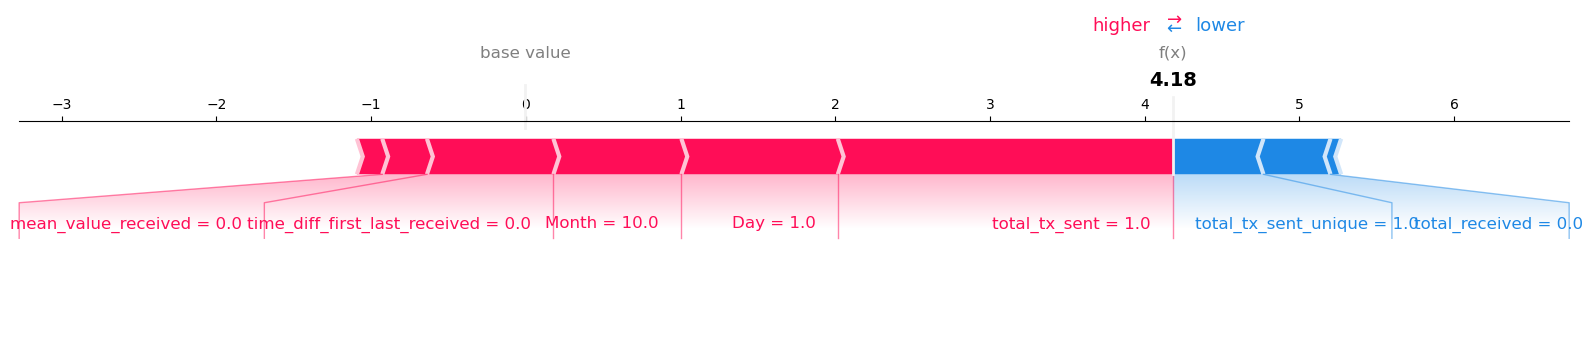

False Positive Example SHAP Force Plot:


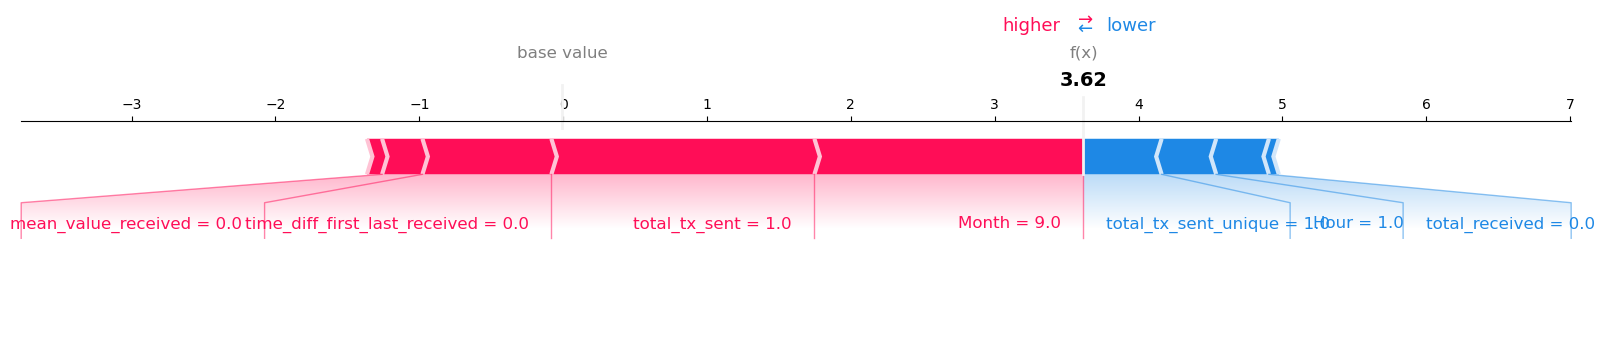

In [39]:
# probabilities and custom predictions
y_prob_beh = model_b_tuned.predict_proba(X_val_beh)[:, 1]
y_pred_beh = (y_prob_beh >= 0.8115).astype(int)

# mask arrays
is_fraud = (y_val == 1).values
is_legit = (y_val == 0).values
tp_idx = np.where((y_pred_beh == 1) & is_fraud)[0][0]
fp_idx = np.where((y_pred_beh == 1) & is_legit)[0][0]

# True Positive example
print("True Positive Example SHAP Force Plot:")
shap.force_plot(
    explainer.expected_value,
    shap_values[tp_idx, :],
    X_val_beh.iloc[tp_idx, :],
    matplotlib=True
)

# False Positive example
print("False Positive Example SHAP Force Plot:")
shap.force_plot(
    explainer.expected_value,
    shap_values[fp_idx, :],
    X_val_beh.iloc[fp_idx, :],
    matplotlib=True
)

True Positive Example SHAP Waterfall Plot:


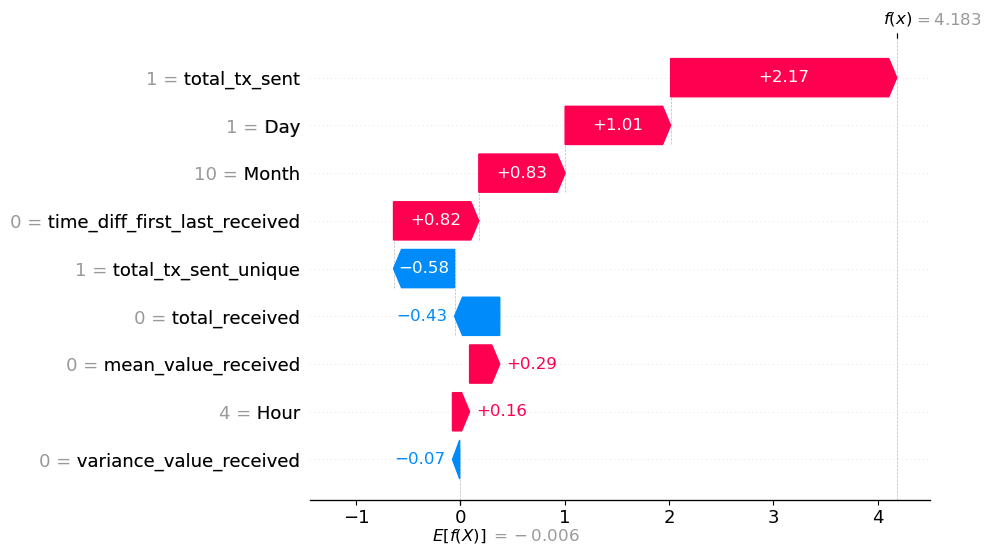

False Positive Example SHAP Waterfall Plot:


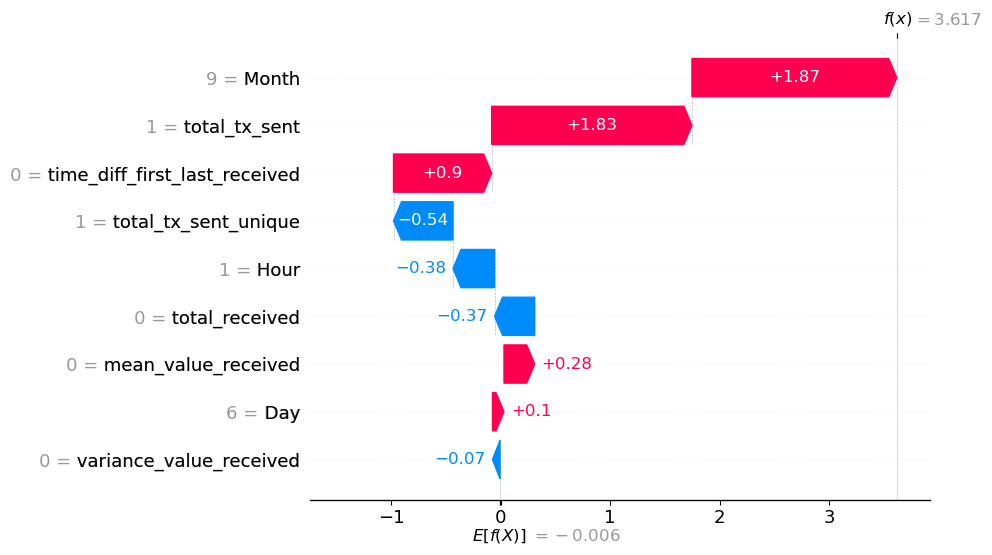

In [40]:
explainer = shap.TreeExplainer(model_b_tuned)
shap_values_obj = explainer(X_val_beh)

# True Positive Index
print("True Positive Example SHAP Waterfall Plot:")
shap.plots.waterfall(shap_values_obj[tp_idx])

# False Positive Index
print("False Positive Example SHAP Waterfall Plot:")
shap.plots.waterfall(shap_values_obj[fp_idx])

In [41]:
target_idx = tp_idx
feature_names = X_val_beh.columns
feature_values = X_val_beh.iloc[target_idx].values

shap_contributions = shap_values[target_idx] 

df_explanation = pd.DataFrame({
    'Feature': feature_names,
    'Value_in_Row': feature_values,
    'SHAP_Contribution': shap_contributions
})

df_explanation['Abs_Contribution'] = df_explanation['SHAP_Contribution'].abs()
df_explanation = df_explanation.sort_values(by='Abs_Contribution', ascending=False).drop(columns='Abs_Contribution')

print(f"Base Probability (Expected Value): {explainer.expected_value:.4f}")
print(f"Final Prediction Probability: {y_prob_beh[target_idx]:.4f}")
print("\n--- Top 10 Features Driving This Prediction ---")
print(df_explanation.head(10))

Base Probability (Expected Value): -0.0056
Final Prediction Probability: 0.9850

--- Top 10 Features Driving This Prediction ---
                         Feature  Value_in_Row  SHAP_Contribution
7                  total_tx_sent           1.0           2.166971
1                            Day           1.0           1.010989
0                          Month          10.0           0.827251
6  time_diff_first_last_received           0.0           0.817456
8           total_tx_sent_unique           1.0          -0.584699
5                 total_received           0.0          -0.433348
3            mean_value_received           0.0           0.288977
2                           Hour           4.0           0.163951
4        variance_value_received           0.0          -0.068690


In [42]:
target_idx = fp_idx
feature_names = X_val_beh.columns
feature_values = X_val_beh.iloc[target_idx].values

shap_contributions = shap_values[target_idx] 

df_explanation = pd.DataFrame({
    'Feature': feature_names,
    'Value_in_Row': feature_values,
    'SHAP_Contribution': shap_contributions
})

df_explanation['Abs_Contribution'] = df_explanation['SHAP_Contribution'].abs()
df_explanation = df_explanation.sort_values(by='Abs_Contribution', ascending=False).drop(columns='Abs_Contribution')

print(f"Base Probability (Expected Value): {explainer.expected_value:.4f}")
print(f"Final Prediction Probability: {y_prob_beh[target_idx]:.4f}")
print("\n--- Top 10 Features Driving This Prediction ---")
print(df_explanation.head(10))

Base Probability (Expected Value): -0.0056
Final Prediction Probability: 0.9738

--- Top 10 Features Driving This Prediction ---
                         Feature  Value_in_Row  SHAP_Contribution
0                          Month           9.0           1.870160
7                  total_tx_sent           1.0           1.828582
6  time_diff_first_last_received           0.0           0.896390
8           total_tx_sent_unique           1.0          -0.543396
2                           Hour           1.0          -0.379363
5                 total_received           0.0          -0.366496
3            mean_value_received           0.0           0.280543
1                            Day           6.0           0.104933
4        variance_value_received           0.0          -0.068723


# Error Analysis

In [43]:
# categorize validation set predictions
model = model_b_tuned
X_analyze = X_val_beh.copy()
y_true = y_val.copy()
threshold = 0.8115

y_prob = model.predict_proba(X_analyze)[:, 1]
y_pred = (y_prob >= threshold).astype(int)

# 'outcome' function
def get_outcome(row):
    if row['Actual'] == 1 and row['Predicted'] == 1:
        return 'TP (Caught Fraud)'
    elif row['Actual'] == 0 and row['Predicted'] == 1:
        return 'FP (False Alarm)'
    elif row['Actual'] == 1 and row['Predicted'] == 0:
        return 'FN (Missed Fraud)'
    else:
        return 'TN (Normal)'

df_analysis = X_analyze.copy()
df_analysis['Actual'] = y_true
df_analysis['Predicted'] = y_pred
df_analysis['Outcome'] = df_analysis.apply(get_outcome, axis=1)

print("Outcome Counts:")
print(df_analysis['Outcome'].value_counts())

Outcome Counts:
Outcome
TN (Normal)          6200
TP (Caught Fraud)    5098
FN (Missed Fraud)    1277
FP (False Alarm)      175
Name: count, dtype: int64


In [44]:
df_analysis

,Month,Day,Hour,mean_value_received,variance_value_received,total_received,time_diff_first_last_received,total_tx_sent,total_tx_sent_unique,Actual,Predicted,Outcome
75121,10,1,4,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1,1,TP (Caught Fraud)
72273,3,6,14,0.000000,0.000000,0.000000,0.000000,4.0,3.0,1,0,FN (Missed Fraud)
77189,6,5,15,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1,1,TP (Caught Fraud)
67666,12,23,22,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1,0,FN (Missed Fraud)
84356,8,7,15,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1,1,TP (Caught Fraud)
...,...,...,...,...,...,...,...,...,...,...,...,...
84432,5,29,11,0.766892,0.065249,1.533785,4.838576,3.0,2.0,1,1,TP (Caught Fraud)
25657,4,21,13,0.001886,0.000000,0.001886,0.000000,1.0,1.0,0,0,TN (Normal)
81284,3,2,4,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1,1,TP (Caught Fraud)
46087,7,22,17,0.586097,0.227920,14.652437,13.547697,54.0,38.0,1,1,TP (Caught Fraud)



--- Statistics for time_diff_first_last_received ---
                    count        mean         50%         std
Outcome                                                      
FN (Missed Fraud)  1277.0   35.019080    0.000000  202.416440
FP (False Alarm)    175.0   18.328835    0.000000  152.028203
TN (Normal)        6200.0  514.033725  335.524381  587.925769
TP (Caught Fraud)  5098.0  129.416245    0.000000  375.749228
----------------------------------------

--- Statistics for total_tx_sent ---
                    count         mean    50%          std
Outcome                                                   
FN (Missed Fraud)  1277.0    31.800313    1.0   151.783447
FP (False Alarm)    175.0    52.268571    1.0   182.083352
TN (Normal)        6200.0  1148.640000  177.0  2372.201751
TP (Caught Fraud)  5098.0   203.576893    4.0   427.496185
----------------------------------------


/var/folders/9j/_8sx8kxj7cl3vnn7_kxmts1m0000gn/T/ipykernel_93084/2983002023.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/9j/_8sx8kxj7cl3vnn7_kxmts1m0000gn/T/ipykernel_93084/2983002023.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/9j/_8sx8kxj7cl3vnn7_kxmts1m0000gn/T/ipykernel_93084/2983002023.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.





--- Statistics for total_received ---
                    count         mean      50%           std
Outcome                                                      
FN (Missed Fraud)  1277.0     8.412763  0.00000     80.321138
FP (False Alarm)    175.0     8.531644  0.00000     56.714174
TN (Normal)        6200.0  8397.754744  5.25162  46689.507448
TP (Caught Fraud)  5098.0    48.111799  0.00000    150.530341
----------------------------------------


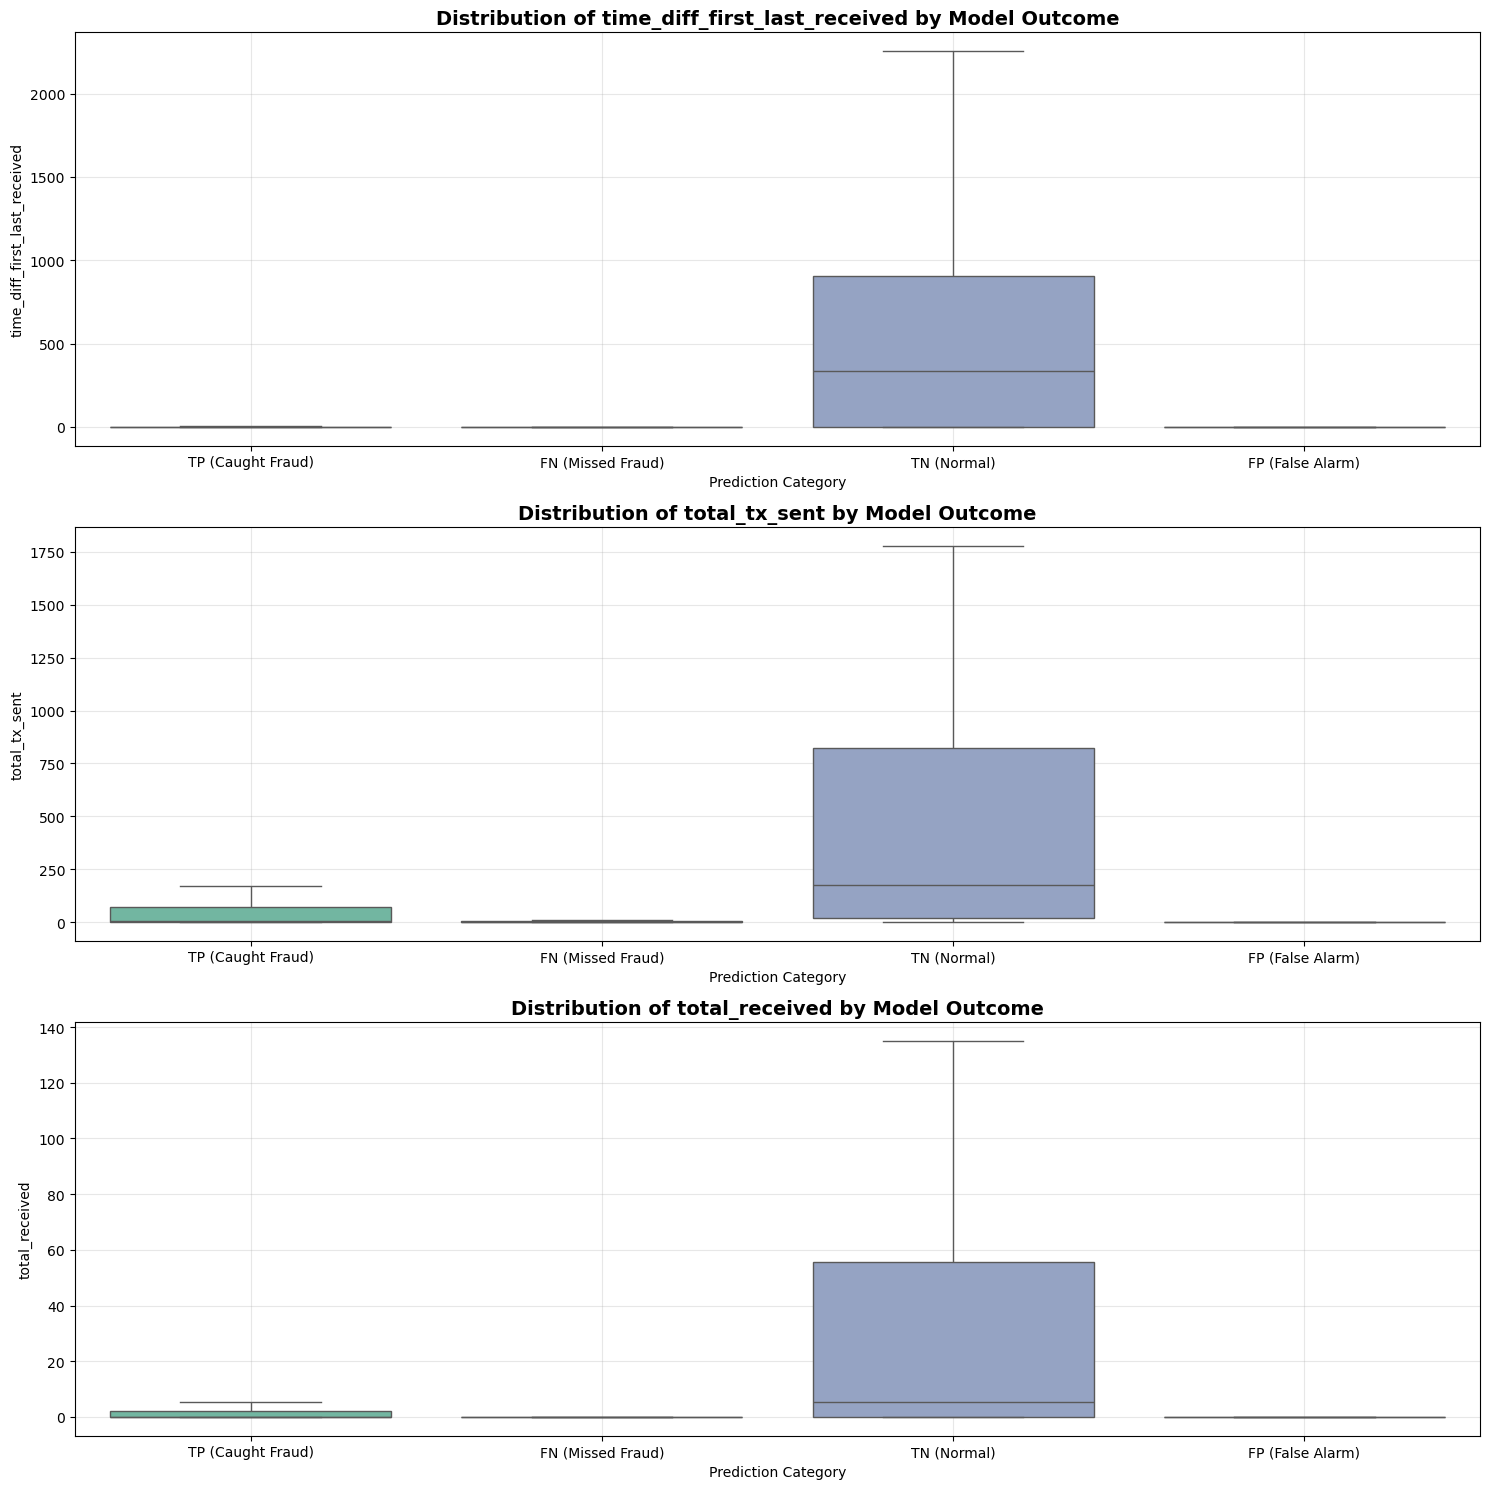

In [45]:
# features to analyze (SHAP Top 3 for scenario B)
features_to_plot = ['time_diff_first_last_received', 'total_tx_sent', 'total_received']

plt.figure(figsize=(15, 5 * len(features_to_plot)))

for i, feature in enumerate(features_to_plot):
    plt.subplot(len(features_to_plot), 1, i+1)

    ax = sns.boxplot(x='Outcome', y=feature, data=df_analysis, palette='Set2', showfliers=False)
    
    plt.title(f'Distribution of {feature} by Model Outcome', fontsize=14, fontweight='bold')
    plt.ylabel(feature)
    plt.xlabel("Prediction Category")
    plt.grid(True, alpha=0.3)

    print(f"\n--- Statistics for {feature} ---")
    stats = df_analysis.groupby('Outcome')[feature].describe()[['count', 'mean', '50%', 'std']]
    print(stats)
    print("-" * 40)

plt.tight_layout()
plt.show()

In [46]:
fig5 = go.Figure()
features_to_plot = ['time_diff_first_last_received', 'total_tx_sent', 'total_received']
for feature in features_to_plot:
    fig5.add_trace(go.Box(y=df_analysis[feature], x=df_analysis['Outcome'], name=feature,
                          visible=(feature=='time_diff_first_last_received')))

fig5.update_layout(
    updatemenus=[dict(
        buttons=list([
            dict(label="Time Difference",
                 method="update",
                 args=[{"visible": [True, False, False]},
                       {"title": "<b>Distribution of Time Difference (Zoom in to see 0-100 range)</b>"}]),
            dict(label="Total Tx Sent",
                 method="update",
                 args=[{"visible": [False, True, False]},
                       {"title": "<b>Distribution of Total Transactions Sent</b>"}]),
            dict(label="Total Received",
                 method="update",
                 args=[{"visible": [False, False, True]},
                       {"title": "<b>Distribution of Total Received (ETH)</b>"}]),
        ]),
        direction="down", showactive=True,
        x=1.0,
        xanchor="right",
        y=1.15,
        yanchor="top"
    )],
    title='<b>Error Analysis: Why did the model misclassify? (Select Feature)</b>',
    template='plotly_white', height=600
)
fig5.write_html("../assets/asset5_error_interactive.html")
fig5.show()